# Sentiment Analyst with Random Forest



## Data Gathering
Data diambil dari commment pada youtube mengunakan api youtube.

[Link Video Youtube](https://www.youtube.com/live/UwrmlpZtVpE)

Video tersebut merupakan video debat capres pada pemilu 2024 yang pertama dan disiarkan pada kanal youtube tvOne.

Untuk proses crawling commentar saya menggunakan code python dari kanal youtube [Ahmad Solichin](/http://youtube.com/c/AchmadSolichin).
[Link Colab](https://colab.research.google.com/drive/1e-0NpFf7mNhWRA203XX3AybggFbWcKUo?usp=sharing)

## Import & Download Library

In [ ]:
# Instal Sastrawi dan pustaka lainnya
!pip install sastrawi
!pip install nltk
# Instal pustaka imbalanced-learn
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.2 MB/s eta 0:00:00


In [ ]:
import re
import pickle
import pandas as pd
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [ ]:
# Pastikan resource yang diperlukan telah diunduh
nltk.download('stopwords')  # untuk stopwords
nltk.download('punkt')  # untuk tokenisasi

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)


Mounted at /content/gdrive/


### Link Data yang sudah dicrawling

In [ ]:

#  = 'https://docs.google.com/spreadsheets/d/1toLYk6XDj7u0rCaK5H6n7vyCobNaRMob4uOdfhOTew4/edit?usp=sharing'
sheet_id = '1toLYk6XDj7u0rCaK5H6n7vyCobNaRMob4uOdfhOTew4'
sheet_name = 'youtube-comments'
data_path = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(data_path)

In [ ]:
# Tampilkan 5 baris pertama data
print("5 Baris Pertama Data:")
print(df.head())

5 Baris Pertama Data:
            publishedAt authorDisplayName  \
0  2024-01-07T18:10:05Z  @griyagadget5158   
1  2024-01-08T06:33:24Z  @daffashidiq1527   
2  2024-01-09T14:12:43Z      @estriani919   
3  2024-01-07T17:21:56Z       @andiok5794   
4  2024-01-07T15:28:55Z  @user-pi9xl7bk1n   

                                         textDisplay  label  likeCount  
0  HARUS NYA DEBAT CALON PRESIDEN ITU TENTANG VIS...    0.0     1022.0  
1  Ini Bukan Debat, Tapi Ini Adalah Acara untuk m...    0.0      715.0  
2  Anis bilang di awal mau menjunjung tinggi etik...    0.0      348.0  
3  Demi Ambisi kekuasaan rela menjatuhkan dan men...    0.0      202.0  
4  Hanya paslon 02 transfaran apa adanya.. paslon...    0.0      202.0  


## Split data

Data terdiri dari 1000 rows yang sudah dilabeli secara manual sedangkan 12000 sisanya belum dilabeli.

Label hanya dikategorikan sebagai positif dan negatif:

Positif Label disimbolkan dengan  1.0

Negatif Label disimbolkan dengan 0.0

In [ ]:
df_without_label = df.iloc[1000:,:]
df = df.iloc[:1000,:]

In [ ]:
df.tail()

,publishedAt,authorDisplayName,textDisplay,label,likeCount
995,2024-01-07T15:32:08Z,@diyatronicdotnet5641,Insyaallah Aman nyaman bersama AMIN,1.0,12.0
996,2024-01-07T15:31:06Z,@sitimaisaroh9067,Saya dari surabsya tetap dukung pak prabowo ji...,1.0,12.0
997,2024-01-07T15:30:33Z,@aguslamongan3099,"Bismillah pak prabowo 1 putaran,..",1.0,12.0
998,2024-01-07T15:25:36Z,@jayhyun719,Licik iyaaa,0.0,12.0
999,2024-01-07T14:57:54Z,@edgarfglennrompis4368,Ini debat program utk kedepan dibidang pertaha...,0.0,12.0


### Plotting Perbedaan Jumlah Label

Label terdapat perbedaan jumlah yang besar

<Axes: xlabel='label', ylabel='count'>

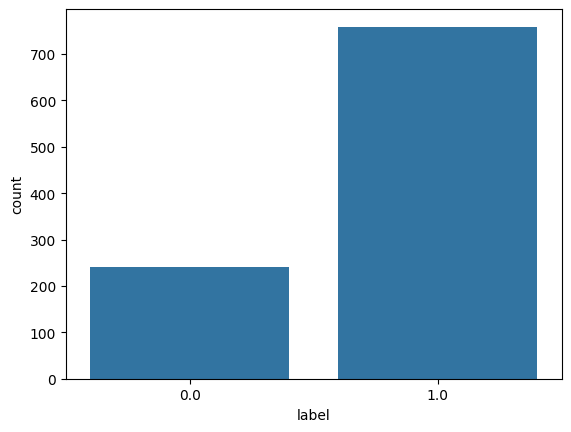

In [ ]:
import seaborn as sns
sns.countplot(x='label', data=df)

## Fungsi untuk Data Clearning



*   remove_emoji : untuk menghilankan emoji yang ada pada teks
*   cleanhtml : untuk menghilangkan tag HTML yang ada pada teks, terutama tag '<\br>' yang sering muncul
*   remove_link : untuk menghapus semua link yang ada
*   to_lower : untuk menyamakan bentuk alphabe dengan format huruf kecil
*   remove_special_characters : untuk menghapus semua spesial karakter
*   remove_stopwords_indonesia : menghilangkan stopword indonesia pada huruf
* stem_with_sastrawi : melakukan stemming pada teks





In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return emoji_pattern.sub(r' ', text)

In [ ]:
def cleanhtml(text):
  html_pattern = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
  text = re.sub(html_pattern, '', text)
  return text

In [ ]:
# Fungsi untuk menghilangkan tautan
def remove_links(text):
    text = re.sub(r'http\S+', '', text)  # Menghapus URL
    return text

In [ ]:
# Fungsi untuk menghilangkan karakter khusus dan tanda baca
def remove_special_characters(text):
    # Menghapus karakter selain huruf dan spasi
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

In [ ]:
# Fungsi untuk mengubah teks ke huruf kecil
def to_lower(text):
    return text.lower()

In [ ]:
# Fungsi untuk menghilangkan stopwords bahasa Indonesia
def remove_stopwords_indonesia(text):
    tokens = word_tokenize(text)  # Tokenisasi teks
    filtered_words = [word for word in tokens if word not in stopwords_indonesia]
    return ' '.join(filtered_words)

In [ ]:
# Fungsi untuk melakukan stemming menggunakan Sastrawi
def stem_with_sastrawi(text):
    return stemmer.stem(text)

In [ ]:
# Daftar stopword bahasa Indonesia
stopwords_indonesia = set(stopwords.words('indonesian'))

# Membuat stemmer menggunakan Sastrawi
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
def clean_all_data(df, text_column):
  df[text_column] = df[text_column].apply(cleanhtml) # Menghilangkan tag html
  df[text_column] = df[text_column].apply(remove_links)  # Menghilangkan tautan
  df[text_column] = df[text_column].apply(remove_emoji)  # Menghilangkan emoji
  df[text_column] = df[text_column].apply(remove_special_characters)  # Menghilangkan karakter khusus
  df[text_column] = df[text_column].apply(to_lower)  # Mengubah ke huruf kecil
  df[text_column] = df[text_column].apply(remove_stopwords_indonesia)  # Menghilangkan stopwords
  df[text_column] = df[text_column].apply(stem_with_sastrawi)  # Stemming menggunakan Sastrawi
  return df

## Melakukan proses cleaning

In [ ]:
# Kolom yang berisi teks yang ingin kita pra-proses
text_column = 'textDisplay'  # Ubah sesuai nama kolom teks di data Anda

df = clean_all_data(df, text_column)

# Menampilkan 5 baris pertama setelah pra-pemrosesan
print("5 Baris Pertama Setelah Pra-pemrosesan:")
print(df.head())

5 Baris Pertama Setelah Pra-pemrosesan:
            publishedAt authorDisplayName  \
0  2024-01-07T18:10:05Z  @griyagadget5158   
1  2024-01-08T06:33:24Z  @daffashidiq1527   
2  2024-01-09T14:12:43Z      @estriani919   
3  2024-01-07T17:21:56Z       @andiok5794   
4  2024-01-07T15:28:55Z  @user-pi9xl7bk1n   

                                         textDisplay  label  likeCount  
0  nya debat calon presiden visi misi strategi se...    0.0     1022.0  
1  debat acara jatuh prabowo kuat semangat prabow...    0.0      715.0  
2       anis bilang junjung etika debat hilang etika    0.0      348.0  
3  ambisi kuasa rela jatuh cari cela paslon cerda...    0.0      202.0  
4  paslon transfaran paslon serang merndahkan men...    0.0      202.0  


In [ ]:
# Simpan file CSV setelah pra-pemrosesan
output_path = '/content/gdrive/MyDrive/data_analyst_with_python/youtube_comments_preprocess.csv'  # Lokasi untuk menyimpan file CSV baru
# output_path = '/content/output/youtube_comments_preprocess.csv'
df.to_csv(output_path, index=False)  # Simpan tanpa kolom index

print("Data telah disimpan ke file:", output_path)

Data telah disimpan ke file: /content/gdrive/MyDrive/data_analyst_with_python/youtube_comments_preprocess.csv


In [ ]:
data_path = '/content/gdrive/MyDrive/data_analyst_with_python/youtube_comments_preprocess.csv'  # Ganti dengan jalur file CSV Anda
df = pd.read_csv(data_path, sep=',', on_bad_lines='skip', encoding='utf-8-sig')
df

,publishedAt,authorDisplayName,textDisplay,label,likeCount
0,2024-01-07T18:10:05Z,@griyagadget5158,nya debat calon presiden visi misi strategi se...,0.0,1022.0
1,2024-01-08T06:33:24Z,@daffashidiq1527,debat acara jatuh prabowo kuat semangat prabow...,0.0,715.0
2,2024-01-09T14:12:43Z,@estriani919,anis bilang junjung etika debat hilang etika,0.0,348.0
3,2024-01-07T17:21:56Z,@andiok5794,ambisi kuasa rela jatuh cari cela paslon cerda...,0.0,202.0
4,2024-01-07T15:28:55Z,@user-pi9xl7bk1n,paslon transfaran paslon serang merndahkan men...,0.0,202.0
...,...,...,...,...,...
995,2024-01-07T15:32:08Z,@diyatronicdotnet5641,insyaallah aman nyaman amin,1.0,12.0
996,2024-01-07T15:31:06Z,@sitimaisaroh9067,surabsya dukung prabowo jibran,1.0,12.0
997,2024-01-07T15:30:33Z,@aguslamongan3099,bismillah prabowo putar,1.0,12.0
998,2024-01-07T15:25:36Z,@jayhyun719,licik iyaaa,0.0,12.0


### Pengecekan ulang data set yang sudah dipra-proses

In [ ]:
df.isnull().sum()

publishedAt           0
authorDisplayName     0
textDisplay          40
label                 1
likeCount             0
dtype: int64

In [ ]:
df['textDisplay'] = df['textDisplay'].fillna(value=' ')

In [ ]:
df.isnull().sum()

publishedAt          0
authorDisplayName    0
textDisplay          0
label                1
likeCount            0
dtype: int64

## Melakukan TF-ID pada dataset

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
# Membaca data
# data_path = '/content/gdrive/MyDrive/data_analyst_with_python/youtube_comments_preprocess.csv'  # Ganti dengan jalur file CSV Anda
# df = pd.read_csv(data_path, sep=',', on_bad_lines='skip')

# Kolom yang berisi teks untuk diekstraksi
text_column = 'textDisplay'  # Ubah sesuai nama kolom teks yang ingin Anda ekstraksi

# Inisialisasi TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # Jumlah maksimal fitur (kata) yang ingin diekstraksi
    min_df=3,  # Kata yang muncul kurang dari 3 kali akan diabaikan
    max_df=0.8,  # Kata yang muncul di lebih dari 80% dokumen akan diabaikan
    ngram_range=(1, 2),  # Ekstrak unigrams dan bigrams
    stop_words=None,  # Stopwords sudah dihilangkan sebelumnya
)

# Lakukan ekstraksi TF-IDF
tfidf_matrix = tfidf_vectorizer.fit_transform(df[text_column])  # Mengubah teks menjadi matriks TF-IDF

# Menampilkan bentuk matriks TF-IDF
print("Bentuk matriks TF-IDF:", tfidf_matrix.shape)

# Menampilkan beberapa fitur (kata-kata)
feature_names = tfidf_vectorizer.get_feature_names_out()  # Mendapatkan nama fitur
print("Beberapa fitur yang diekstraksi:")
print(feature_names[:10])  # Menampilkan 10 fitur pertama

# Save the vectorizer
pickle.dump(tfidf_vectorizer, open("tfidf_vectorizer.pickle", "wb"))
!cp tfidf_vectorizer.pickle /content/gdrive/MyDrive/data_analyst_with_python/
print("Fitur TF-IDF telah disimpan ke file '/content/gdrive/MyDrive/data_analyst_with_python/tfidf_youtube_comment.pickle'")


Bentuk matriks TF-IDF: (1000, 770)
Beberapa fitur yang diekstraksi:
['aamiin' 'aamiin ya' 'abah' 'abdi' 'abis' 'adil' 'adil makmur' 'agama'
 'air' 'aja']
Fitur TF-IDF telah disimpan ke file '/content/gdrive/MyDrive/data_analyst_with_python/tfidf_youtube_comment.pickle'


## Spliting data set menjadi train/test dan melakukan oversampling terhadap dataset yang ada

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pickle

text_column = 'textDisplay'  # Ubah sesuai nama kolom teks yang ingin Anda ekstraksi
tfidf_vectorizer = pickle.load(open("/content/gdrive/MyDrive/data_analyst_with_python/tfidf_youtube_comment.pickle", "rb"))

# Pastikan tidak ada NaN atau nilai kosong di kolom label
df['label'].fillna(1, inplace=True)  # Mengisi nilai kosong dengan nilai default

# Pisahkan data menjadi pelatihan dan pengujian
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

X_train = tfidf_vectorizer.fit_transform(train_df[text_column])  # Fitur untuk pelatihan
X_test = tfidf_vectorizer.transform(test_df[text_column])  # Fitur untuk pengujian
y_train = train_df['label']  # Label numerik untuk pelatihan
y_test = test_df['label']  # Label numerik untuk pengujian

# Oversampling dengan SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)  # Menyeimbangkan data pelatihan


## Melakukan proses fitting data pada model Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# RF_classifier = RandomForestClassifier(n_estimators= 120, criterion='gini', max_depth=1000)
RF_classifier = RandomForestClassifier(n_estimators=200)
RF_classifier.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(n_estimators=200)

Melakukan prediksi pada data baru dengan model yang sudah ditrain.

In [ ]:
y_pred_RF = RF_classifier.predict(X_test)

y_pred_RF

array([1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.])

## Melakukan evaluasi dengan confusion matrix, accuracy dan classification report

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report #for testing the model accuracy
cm_RF = confusion_matrix(y_test, y_pred_RF)
acc_RF=accuracy_score(y_test, y_pred_RF)


In [ ]:
cm_RF

array([[ 15,  33],
       [ 20, 132]])

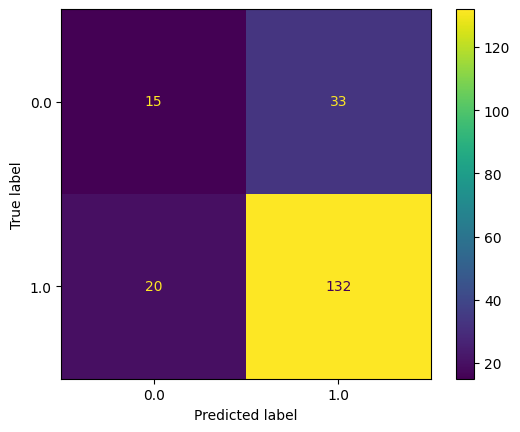

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF,
                              display_labels=RF_classifier.classes_)
disp.plot()

In [ ]:
acc_RF

0.735

### Melakukan classification report

In [ ]:
a=classification_report(y_test, y_pred_RF, output_dict=True)

print(a)

{'0.0': {'precision': 0.42857142857142855, 'recall': 0.3125, 'f1-score': 0.3614457831325301, 'support': 48}, '1.0': {'precision': 0.8, 'recall': 0.868421052631579, 'f1-score': 0.832807570977918, 'support': 152}, 'accuracy': 0.735, 'macro avg': {'precision': 0.6142857142857143, 'recall': 0.5904605263157895, 'f1-score': 0.597126677055224, 'support': 200}, 'weighted avg': {'precision': 0.7108571428571429, 'recall': 0.735, 'f1-score': 0.7196807418950248, 'support': 200}}


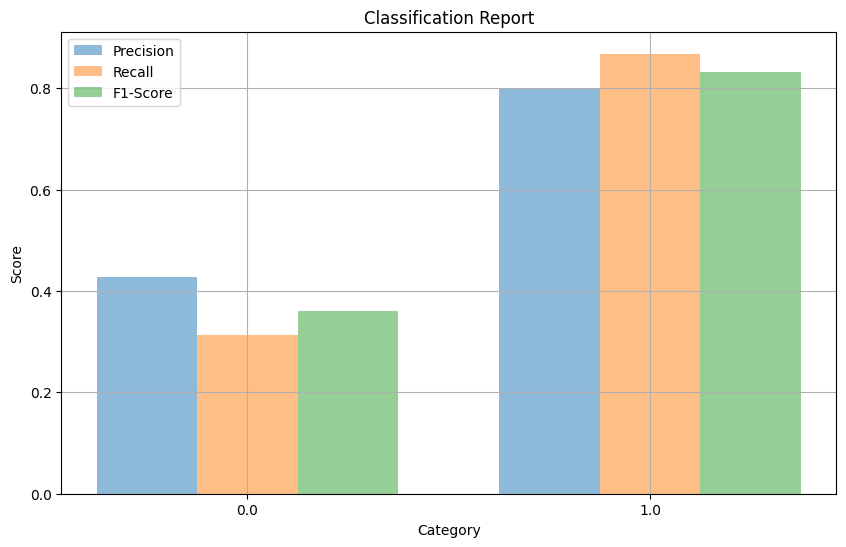

In [ ]:
# Plotting the classification report
fig, ax = plt.subplots(figsize=(10, 6))

# Categories for the classification
categories = list(a.keys())[:-3]  # Exclude 'accuracy', 'macro avg', and 'weighted avg'

# Extracting precision, recall, and f1-score
precision = [a[category]['precision'] for category in categories]
recall = [a[category]['recall'] for category in categories]
f1_score = [a[category]['f1-score'] for category in categories]

# Setting the positions and width for the bars
pos = list(range(len(categories)))
width = 0.25

# Plotting each metric
plt.bar(pos, precision, width, alpha=0.5, label='Precision')
plt.bar([p + width for p in pos], recall, width, alpha=0.5, label='Recall')
plt.bar([p + width*2 for p in pos], f1_score, width, alpha=0.5, label='F1-Score')

# Adding the aesthetics
plt.xlabel('Category')
plt.ylabel('Score')
plt.title('Classification Report')
plt.xticks([p + width for p in pos], categories)

# Adding the legend and showing the plot
plt.legend(['Precision', 'Recall', 'F1-Score'], loc='upper left')
plt.grid()
plt.show()


## Kesimpulan

Model tidak terlalu adaptif dalam mengklasifikasikan negatif sentiment dikarenakan sample yang memiliki kekurangan data negatif.

### Save model Ke Google Drive

In [ ]:
import pickle
# Menyimpan model ke file .pkl
with open('/content/gdrive/MyDrive/data_analyst_with_python/Model_RandomForestClassifier.pkl', 'wb') as file:
    pickle.dump(RF_classifier, file)

print("Model telah disimpan ke Model_RandomForestClassifier.pkl")


Model telah disimpan ke Model_RandomForestClassifier.pkl


### Load Model dari google drive dengan library pickle

In [ ]:
# load model
pickled_model = pickle.load(open('/content/gdrive/MyDrive/data_analyst_with_python/Model_RandomForestClassifier.pkl', 'rb'))
y_pred_RF = pickled_model.predict(X_test)

## Melakukan predicting dengan dataset yang tidak berlabel

In [ ]:
df_new_1 = df_without_label.loc[10999:, ['publishedAt', 'textDisplay', 'label']]
df_new_1

,publishedAt,textDisplay,label
10999,2024-01-07T17:15:31Z,2222ALL IN LAMPUNG,NaN
11000,2024-01-07T17:15:31Z,penutupan yg di bicaraka pak anis saya ga meng...,NaN
11001,2024-01-07T17:15:30Z,Anis ❤,NaN
11002,2024-01-07T17:15:25Z,Intinya 02 03 satu gen 😂,NaN
11003,2024-01-07T17:15:16Z,Tau kan sekarang watak Anis penuh kedengkian,NaN
...,...,...,...
13764,2024-01-07T14:55:35Z,02 maju trs,NaN
13765,2024-01-07T14:55:35Z,"Terimakasih pak Anies,RAKYAT TERCERAHKAN",NaN
13766,2024-01-07T14:51:12Z,😮,NaN
13767,2024-01-07T14:48:58Z,3,NaN


In [ ]:
# Kolom yang berisi teks yang ingin kita pra-proses
text_column = 'textDisplay'  # Ubah sesuai nama kolom teks di data Anda

# Terapkan fungsi pra-pemrosesan pada kolom teks
df_new_1[text_column] = df_new_1[text_column].apply(cleanhtml) # menghilangkan tag html
df_new_1[text_column] = df_new_1[text_column].apply(remove_links)  # Menghilangkan tautan
df_new_1[text_column] = df_new_1[text_column].apply(remove_emoji)  # Menghilangkan emoji
df_new_1[text_column] = df_new_1[text_column].apply(remove_special_characters)  # Menghilangkan karakter khusus
df_new_1[text_column] = df_new_1[text_column].apply(to_lower)  # Mengubah ke huruf kecil
df_new_1[text_column] = df_new_1[text_column].apply(remove_stopwords_indonesia)  # Menghilangkan stopwords
df_new_1[text_column] = df_new_1[text_column].apply(stem_with_sastrawi)  # Stemming menggunakan Sastrawi

# Menampilkan 5 baris pertama setelah pra-pemrosesan
print("5 Baris Pertama Setelah Pra-pemrosesan:")
print(df_new_1.head())


5 Baris Pertama Setelah Pra-pemrosesan:
                publishedAt  \
10999  2024-01-07T17:15:31Z   
11000  2024-01-07T17:15:31Z   
11001  2024-01-07T17:15:30Z   
11002  2024-01-07T17:15:25Z   
11003  2024-01-07T17:15:16Z   

                                             textDisplay  label  
10999                                     all in lampung    NaN  
11000  tutup yg bicaraka anis ga erti yg omong cengko...    NaN  
11001                                               anis    NaN  
11002                                           inti gen    NaN  
11003                        tau watak anis penuh dengki    NaN  


In [ ]:
print(df_new_1.tail())

                publishedAt                                 textDisplay  label
13764  2024-01-07T14:55:35Z                                    maju trs    NaN
13765  2024-01-07T14:55:35Z               terimakasih aniesrakyat cerah    NaN
13766  2024-01-07T14:51:12Z                                                NaN
13767  2024-01-07T14:48:58Z                                                NaN
13768  2024-01-12T02:48:30Z  prestasi anies baswedan jabat gubernur dki    NaN


In [ ]:
# Simpan file CSV setelah pra-pemrosesan
output_path = '/content/gdrive/MyDrive/data_analyst_with_python/1000_batch_7_unlabel_youtube_comments_preprocess.csv'  # Lokasi untuk menyimpan file CSV baru
# output_path = '/content/output/youtube_comments_preprocess.csv'
df_new_1.to_csv(output_path, index=False)  # Simpan tanpa kolom index

print("Data telah disimpan ke file:", output_path)

Data telah disimpan ke file: /content/gdrive/MyDrive/data_analyst_with_python/1000_batch_7_unlabel_youtube_comments_preprocess.csv


In [ ]:
# reuse tfidf_vectorizer
# new_question = "What time is it?"
vectorizer = pickle.load(open("/content/tfidf_vectorizer.pickle", "rb"))
x_train_new = vectorizer.transform(df_new_1['textDisplay'])

In [ ]:
x_train_new = vectorizer.transform(df_new_1['textDisplay'])

In [ ]:
y_new_pred_RF = RF_classifier.predict(x_train_new)

y_new_pred_RF

array([1., 1., 1., ..., 1., 1., 1.])

In [ ]:
y_predic_RF = pd.Series(y_new_pred_RF)

In [ ]:
y_predic_RF

0       1.0
1       1.0
2       1.0
3       1.0
4       0.0
       ... 
2765    1.0
2766    1.0
2767    1.0
2768    1.0
2769    1.0
Length: 2770, dtype: float64

In [ ]:
df_new_1['label'] = y_predic_RF.values

In [ ]:
df_new_1.head()

,publishedAt,textDisplay,label
10999,2024-01-07T17:15:31Z,all in lampung,1.0
11000,2024-01-07T17:15:31Z,tutup yg bicaraka anis ga erti yg omong cengko...,1.0
11001,2024-01-07T17:15:30Z,anis,1.0
11002,2024-01-07T17:15:25Z,inti gen,1.0
11003,2024-01-07T17:15:16Z,tau watak anis penuh dengki,0.0


In [ ]:
# Simpan file CSV setelah pra-pemrosesan
output_path = '/content/gdrive/MyDrive/data_analyst_with_python/1000_batch_6_predic_label_youtube_comments_preprocess.csv'  # Lokasi untuk menyimpan file CSV baru
# output_path = '/content/output/youtube_comments_preprocess.csv'
df_new_1.to_csv(output_path, index=False)  # Simpan tanpa kolom index

print("Data telah disimpan ke file:", output_path)

Data telah disimpan ke file: /content/gdrive/MyDrive/data_analyst_with_python/1000_batch_6_predic_label_youtube_comments_preprocess.csv


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Inisialisasi model-model yang akan dibandingkan
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Naive Bayes': MultinomialNB(),
    'XGBoost': xgb.XGBClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Stratified K-Fold untuk cross-validation
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Membandingkan model-model dengan cross-validation
results = {}

for name, model in models.items():
    # Menggunakan cross-validation untuk mengukur kinerja model
    accuracy = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy').mean()
    f1 = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1_macro').mean()  # F1-score untuk multi-class
    results[name] = {'Accuracy': accuracy, 'F1-Score': f1}

# Menampilkan hasil perbandingan
print("Perbandingan Model:")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  F1-Score: {metrics['F1-Score']:.4f}")


Perbandingan Model:
Random Forest:
  Accuracy: 0.7650
  F1-Score: 0.4577
SVM:
  Accuracy: 0.7587
  F1-Score: 0.4314
Naive Bayes:
  Accuracy: 0.7600
  F1-Score: 0.4318
XGBoost:
  Accuracy: 0.7737
  F1-Score: 0.6279
Decision Tree:
  Accuracy: 0.7675
  F1-Score: 0.6520


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Membaca data
# data_path = '/content/drive/MyDrive/data_analyst_with_python/chatgpt_preprocess.csv'
# df = pd.read_csv(data_path, on_bad_lines='skip')
text_column = 'textDisplay'
# Memastikan tidak ada NaN atau nilai kosong pada kolom label
df['label'].fillna(1, inplace=True)  # Mengisi NaN dengan 'netral'

# Konversi label dari string ke numerik
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])  # Mengubah label ke format numerik

# Pisahkan data menjadi pelatihan dan pengujian
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Ekstraksi TF-IDF untuk data pelatihan dan pengujian
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))  # Menggunakan unigrams, bigrams, dan trigrams
X_train = tfidf_vectorizer.fit_transform(train_df[text_column])  # Fitur untuk pelatihan
X_test = tfidf_vectorizer.transform(test_df[text_column])  # Fitur untuk pengujian
y_train = train_df['label']  # Label untuk pelatihan
y_test = test_df['label']  # Label untuk pengujian


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

# Menyeimbangkan data pelatihan dengan SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Inisialisasi model-model yang akan dibandingkan
models = {
    'Random Forest': RandomForestClassifier(n_estimators=200),
    'SVM': SVC(kernel='linear'),  # Kernel linear
    'Naive Bayes': MultinomialNB(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', n_estimators=200),
    'Decision Tree': DecisionTreeClassifier(max_depth=10)  # Kedalaman pohon maksimum
}

# Stratified K-Fold untuk cross-validation
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Membandingkan model-model dengan cross-validation
results = {}

for name, model in models.items():
    accuracy = cross_val_score(model, X_train_balanced, y_train_balanced, cv=skf, scoring='accuracy').mean()
    f1 = cross_val_score(model, X_train_balanced, y_train_balanced, cv=skf, scoring='f1_macro').mean()  # F1-score untuk multi-class
    results[name] = {'Accuracy': accuracy, 'F1-Score': f1}

print("Perbandingan Model:")
for name, metrics in results.items():
    print(f"{name}:")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  F1-Score: {metrics['F1-Score']:.4f}")


Perbandingan Model:
Random Forest:
  Accuracy: 0.8931
  F1-Score: 0.8934
SVM:
  Accuracy: 0.8676
  F1-Score: 0.8658
Naive Bayes:
  Accuracy: 0.8685
  F1-Score: 0.8671
XGBoost:
  Accuracy: 0.8306
  F1-Score: 0.8304
Decision Tree:
  Accuracy: 0.7451
  F1-Score: 0.7319


In [ ]:
import pickle

# Memuat model dari file .pkl
# name = ['Decision Tree', 'Naive Bayes', 'Random Forest', 'SVM', 'XGBoost']
# for model in name:
with open('Random Forest_model.pkl', 'rb') as file:
  loaded_model = pickle.load(file)


In [ ]:
predictions = loaded_model.predict(df_without_label['textDisplay'])

print("Prediksi:", predictions)


NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.